In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Import JSON file
file_data = 'Data/match_2.json'
# Function to load the contents of the JSON file

def load_json_file(file):
    with open(file, 'r') as f:
        data = json.load(f)
    return data
# Call function to load data into data_df
data_df = load_json_file(file_data)
# Create a pandas DataFrame to simplify analysis
df = pd.DataFrame(data_df)
# General presentation
print("Introducing df:")
print(df.info())

Introducing df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   613 non-null    object
 1   norm    613 non-null    object
dtypes: object(2)
memory usage: 9.7+ KB
None


In [3]:
# Show statistical overview for the "norm" column.
print("\nStatic review of the \"norm\" column:")
print(df['norm'].describe())


Static review of the "norm" column:
count                                                   613
unique                                                  613
top       [104.42423889328715, 87.63989343949717, 128.52...
freq                                                      1
Name: norm, dtype: object


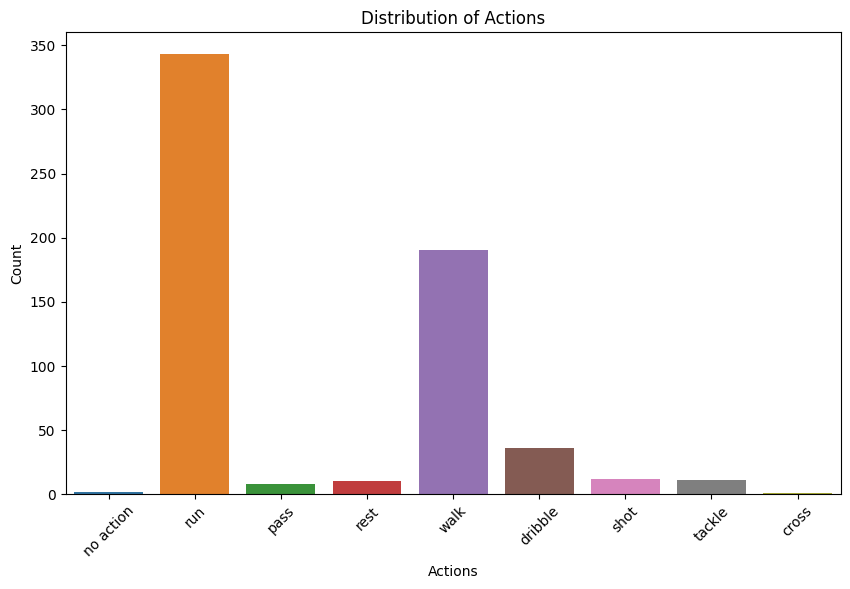

In [4]:
# Distribution of actions according to their occurrence.
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label')
plt.title("Distribution of Actions")
plt.xlabel("Actions")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Our data are unbalanced.

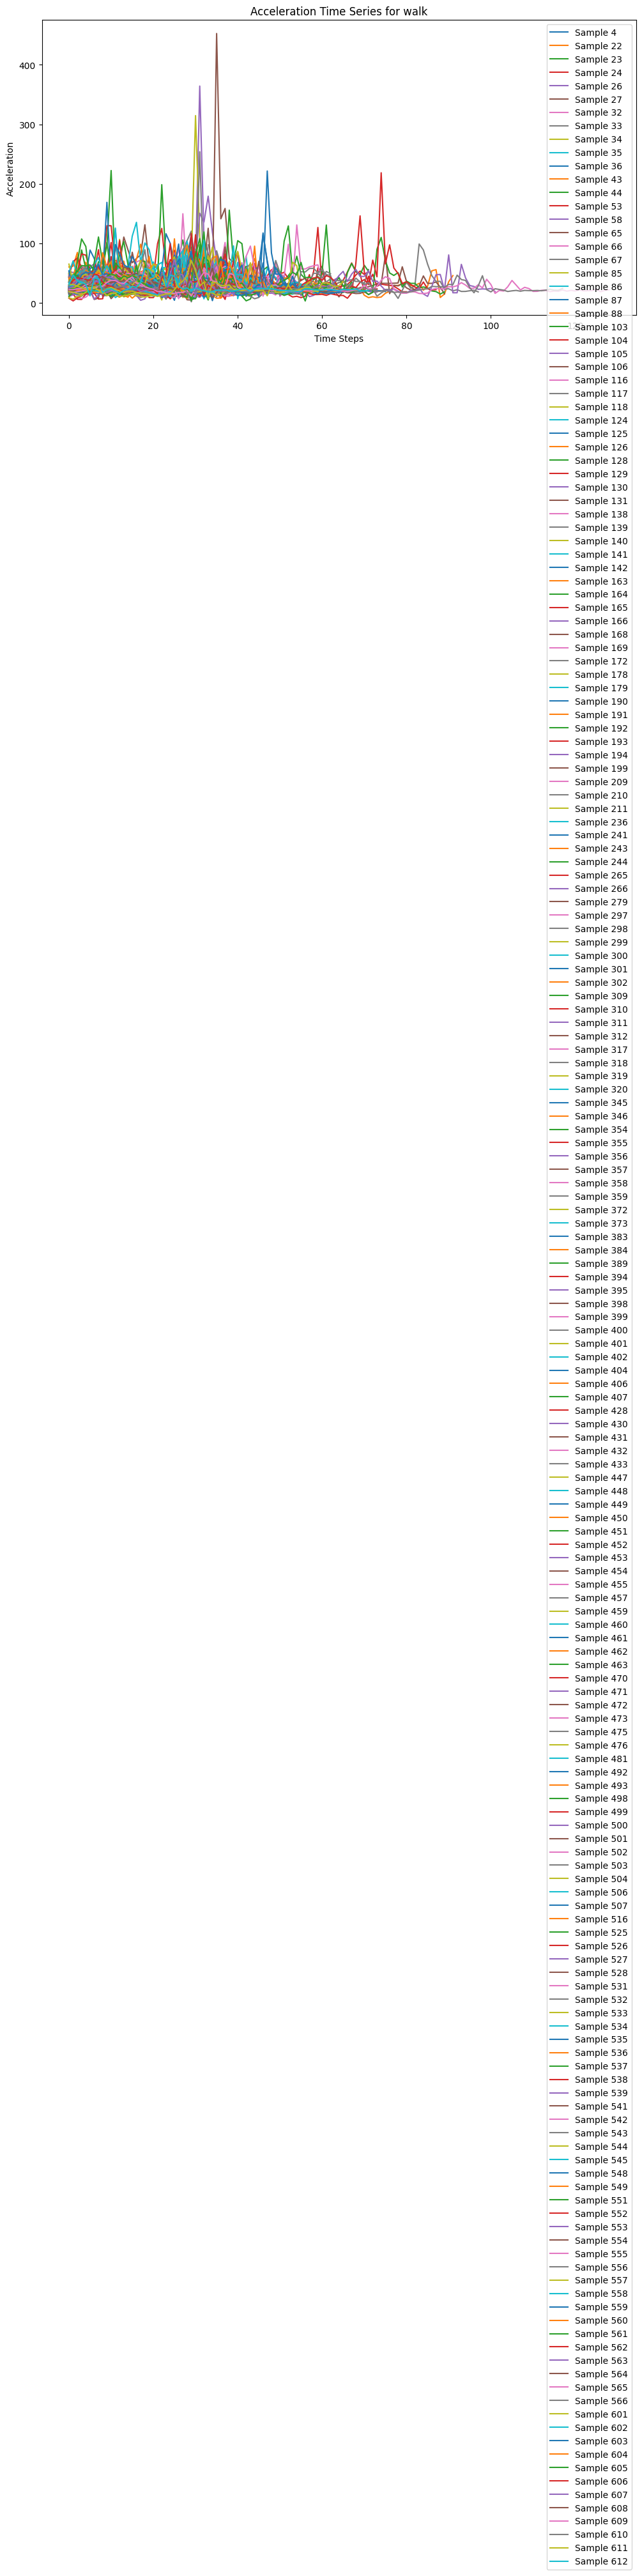

In [5]:
# Time Series Visualization for a specific action (e.g., 'walk')
action_to_plot = 'walk'
subset_df = df[df['label'] == action_to_plot]
plt.figure(figsize=(12, 6))
for idx, row in subset_df.iterrows():
    plt.plot(row['norm'], label=f'Sample {idx}')
plt.title(f"Acceleration Time Series for {action_to_plot}")
plt.xlabel("Time Steps")
plt.ylabel("Acceleration")
plt.legend(loc='upper right')
plt.show()

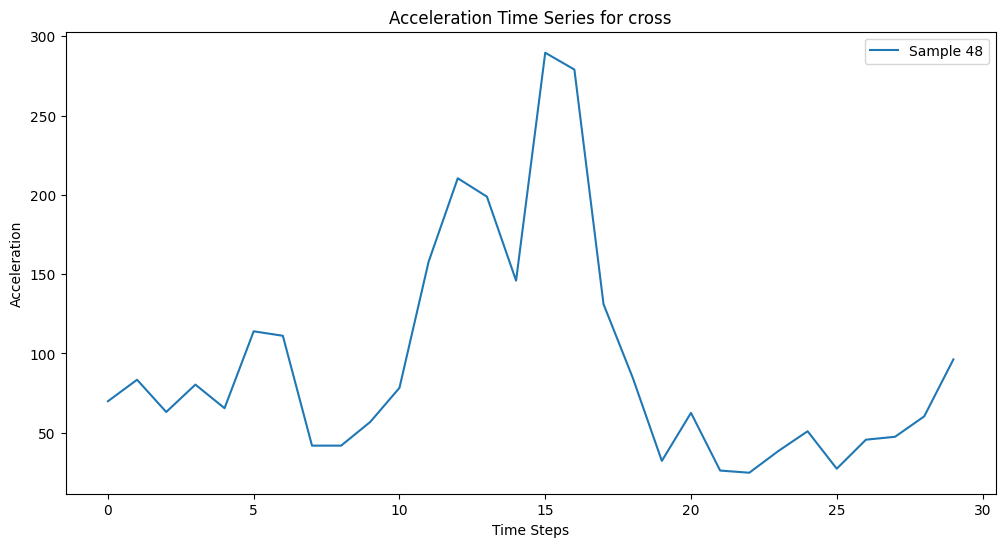

In [6]:
# Time Series Visualization for a specific action (e.g., 'cross')
action_to_plot = 'cross'
subset_df = df[df['label'] == action_to_plot]
plt.figure(figsize=(12, 6))
for idx, row in subset_df.iterrows():
    plt.plot(row['norm'], label=f'Sample {idx}')
plt.title(f"Acceleration Time Series for {action_to_plot}")
plt.xlabel("Time Steps")
plt.ylabel("Acceleration")
plt.legend(loc='upper right')
plt.show()

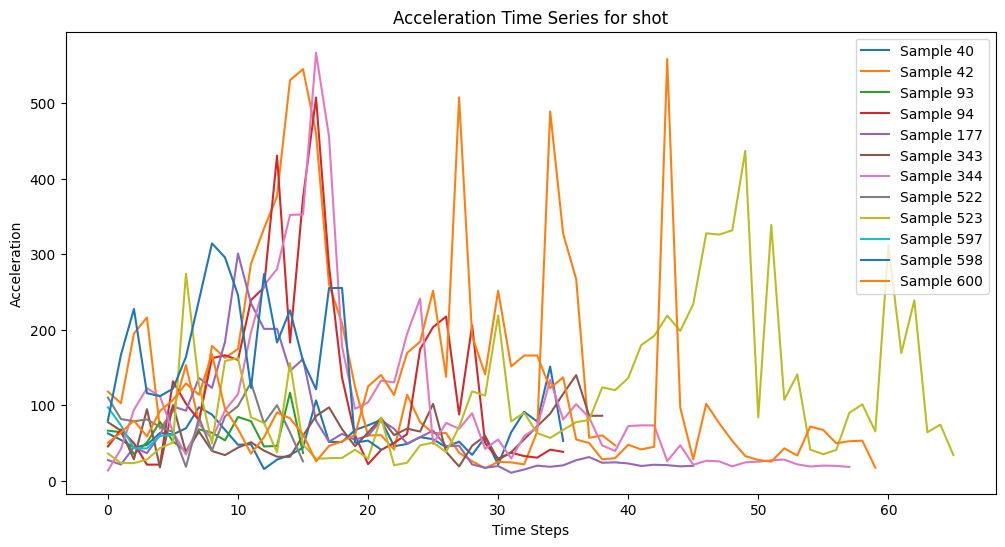

In [7]:
# Time Series Visualization for a specific action (e.g., 'shot')
action_to_plot = 'shot'
subset_df = df[df['label'] == action_to_plot]
plt.figure(figsize=(12, 6))
for idx, row in subset_df.iterrows():
    plt.plot(row['norm'], label=f'Sample {idx}')
plt.title(f"Acceleration Time Series for {action_to_plot}")
plt.xlabel("Time Steps")
plt.ylabel("Acceleration")
plt.legend(loc='upper right')
plt.show()

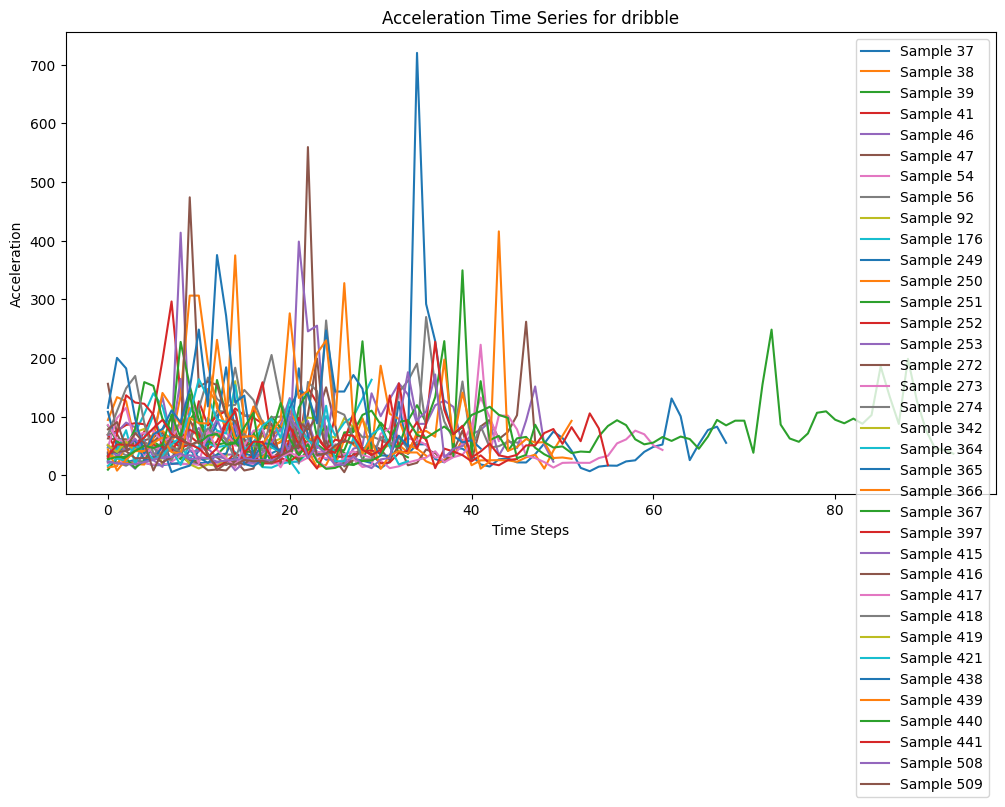

In [8]:
# Time Series Visualization for a specific action (e.g., 'dribble')
action_to_plot = 'dribble'
subset_df = df[df['label'] == action_to_plot]
plt.figure(figsize=(12, 6))
for idx, row in subset_df.iterrows():
    plt.plot(row['norm'], label=f'Sample {idx}')
plt.title(f"Acceleration Time Series for {action_to_plot}")
plt.xlabel("Time Steps")
plt.ylabel("Acceleration")
plt.legend(loc='upper right')
plt.show()

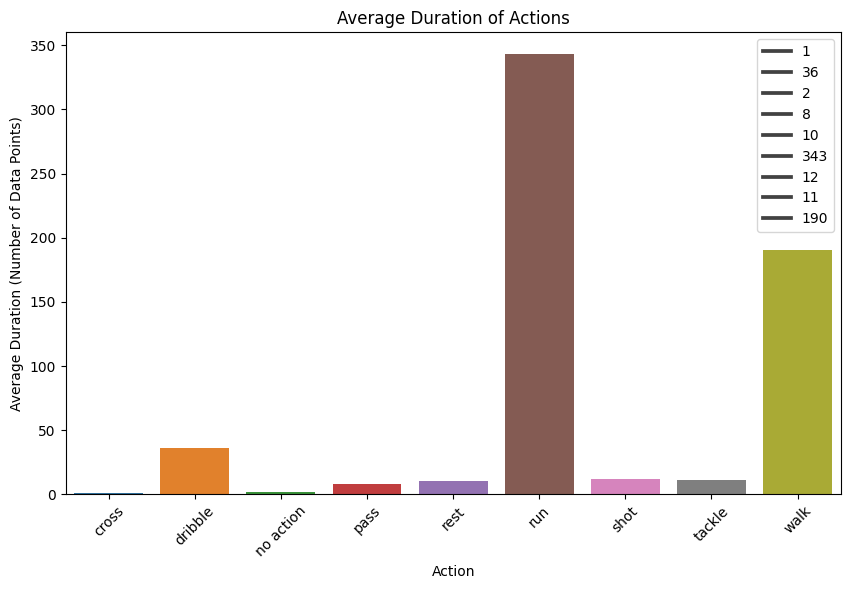

In [9]:
# Action Duration Analysis
action_durations = df.groupby('label', group_keys=False)['norm'].apply(lambda x: len(x))
plt.figure(figsize=(10, 6))
sns.barplot(x=action_durations.index, y=action_durations.values)
plt.title("Average Duration of Actions")
plt.xlabel("Action")
plt.ylabel("Average Duration (Number of Data Points)")
plt.legend(action_durations)
plt.xticks(rotation=45)
plt.show()

In [10]:
for i in df['label'].unique():
    av_len_action=[len(l) for l in df[df['label']==i]['norm']]
    print("Average length of the gait "+i,np.mean(av_len_action))

Average length of the gait no action 134.0
Average length of the gait run 37.24781341107872
Average length of the gait pass 50.375
Average length of the gait rest 181.4
Average length of the gait walk 54.78947368421053
Average length of the gait dribble 36.52777777777778
Average length of the gait shot 36.75
Average length of the gait tackle 49.90909090909091
Average length of the gait cross 30.0


In [11]:
medians = df.groupby('label')['norm'].apply(lambda x: np.median(x)).reset_index()
print(medians)

       label                                               norm
0      cross  [69.90252965377255, 83.44774477223854, 63.1005...
1    dribble  [20.438582935130697, 18.61369033818308, 12.330...
2  no action  [25.6410364212469, 22.69086791712746, 17.00228...
3       pass  [25.59700180521342, 32.58763146018611, 36.2568...
4       rest  [11.193330506174632, 10.646882513198419, 11.24...
5        run  [44.50734247837226, 37.09489864733479, 31.9927...
6       shot  [31.252847368342312, 26.940338423197655, 21.95...
7     tackle  [47.54874580511817, 58.22035620738969, 86.1880...
8       walk  [11.088072118189928, 13.485994371395426, 16.34...


<ipython-input-12-645663557638>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  medians[f'norm_{i}_median'] = medians['norm'].apply(lambda x: x[i] if i < len(x) else None)
<ipython-input-12-645663557638>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  medians[f'norm_{i}_median'] = medians['norm'].apply(lambda x: x[i] if i < len(x) else None)
<ipython-input-12-645663557638>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

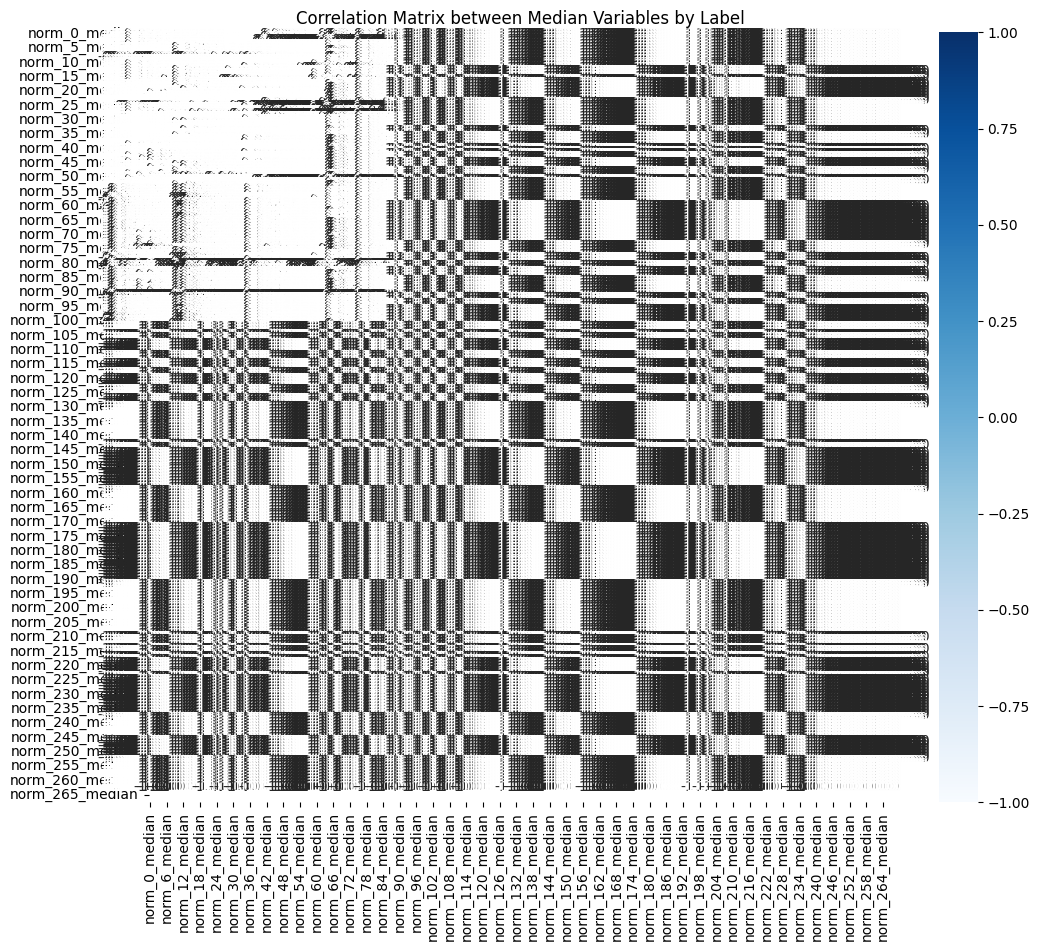

In [12]:
# Create a column for each variable containing the median of 'norm'.
max_length = max(len(entry) for entry in medians['norm'])
for i in range(max_length):
    medians[f'norm_{i}_median'] = medians['norm'].apply(lambda x: x[i] if i < len(x) else None)

# Calculate the correlation matrix
correlation_matrix = medians.corr(numeric_only = True)

# Show a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".10f", cmap="Blues")
plt.title('Correlation Matrix between Median Variables by Label')
plt.show()

In [13]:
medians.corr(numeric_only = True)

,norm_0_median,norm_1_median,norm_2_median,norm_3_median,norm_4_median,norm_5_median,norm_6_median,norm_7_median,norm_8_median,norm_9_median,...,norm_258_median,norm_259_median,norm_260_median,norm_261_median,norm_262_median,norm_263_median,norm_264_median,norm_265_median,norm_266_median,norm_267_median
norm_0_median,1.000000,0.964946,0.783745,0.787196,0.877703,0.815770,0.611405,0.494619,-0.077167,0.919617,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
norm_1_median,0.964946,1.000000,0.866280,0.886110,0.926751,0.866810,0.690933,0.426373,-0.119856,0.854702,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
norm_2_median,0.783745,0.866280,1.000000,0.991127,0.951628,0.556373,0.434238,0.311514,-0.198106,0.731840,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
norm_3_median,0.787196,0.886110,0.991127,1.000000,0.946253,0.614734,0.492475,0.337316,-0.249409,0.703308,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
norm_4_median,0.877703,0.926751,0.951628,0.946253,1.000000,0.704278,0.520475,0.394526,-0.065762,0.862004,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
norm_263_median,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
norm_264_median,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
norm_265_median,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
norm_266_median,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
# Data refund : Sequences are completed to ensure consistent length.
max_sequence_length = 100
X_padded = tf.keras.preprocessing.sequence.pad_sequences(df['norm'].tolist(), padding='post', maxlen=102, dtype='float32')
print(len(X_padded[0]))
print(len(X_padded[5]))
print(len(X_padded[159]))
#Label Encoding: Actions are encoded into numerical labels using the LabelEncoder.
label_encoder = LabelEncoder()
numerical_labels = label_encoder.fit_transform(df['label'])
numerical_labels[:15]
print(np.unique(numerical_labels))
X = X_padded
y = numerical_labels
#Data Balancing:  We use SMOTE to balance the dataset to avoid class imbalance.
from imblearn.over_sampling import SMOTE
from collections import Counter
# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy={1: 102}, random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X, y)
# Count the class distribution after SMOTE
print("Class distribution following SMOTE :", Counter(y_resampled))
#Feature Engineering: You calculate mean and standard deviation features for each sequence.
mean_values = np.mean(X_resampled, axis=1)
std_values = np.std(X_resampled, axis=1)
X_with_mean_std = np.hstack((X_resampled, mean_values.reshape(-1, 1), std_values.reshape(-1, 1)))
X_with_mean_std.shape
#Splitting your preprocessed data into three sets
X_train, X_temp, y_train, y_temp = train_test_split(X_with_mean_std, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
#y_train_c = tf.keras.utils.to_categorical(y_train, num_classes=8)


102
102
102
[0 1 2 3 4 5 6 7 8]
Class distribution following SMOTE : Counter({5: 343, 8: 190, 1: 102, 6: 12, 7: 11, 4: 10, 3: 8, 2: 2, 0: 1})


In [84]:
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
# Define playstyle labels (e.g., 'attacking', 'defending', 'normal')
playstyle_labels = np.array(['attacking', 'defending', 'normal'])


#building the LSTM model
def build_lstm_model(input_shape=(102, 1)):
# build a model layer by layer, sequentially
    model = models.Sequential()
    model.add(layers.LSTM(128, input_shape=(102, 1), return_sequences=True))
# The layers of dropout are used to avoid the adjustment with a rate of 0.2
    model.add(Dropout(0.2))
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
# The layer does not return sequences. => Generates a single output.
    model.add(layers.LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
# A softmax activation function is used to predict the class (it assigns probabilities to each possible class).
    model.add(layers.Dense(8, activation='softmax'))
# Optimizer adam minimizes the loss defined by the "categorical_crossentropy" loss function
# Accuracy gives an overall idea of model performance
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
#Accuracy alone may not be a sufficient metric for assessing a model's performance.
#categorical_crossentropy (loss) is more significant
#This section involves training the LSTM model with weighted loss. You define class weights based on the playstyle
#(e.g., 'attacking' or 'defending') and train the model on the training data
def train_model_with_weighted_loss(model, X_train, y_train, X_val, y_val, epochs, batch_size, playstyle):
    # Define the weight for the loss function based on the playstyle
    if playstyle == 'attacking':
        class_weights = {label_encoder.transform(['shot'])[0]: 8.0,
                         label_encoder.transform(['pass'])[0]: 4.0,
                         label_encoder.transform(['dribble'])[0]: 5.0,
                        label_encoder.transform(['rest'])[0]: 1.0,
                         label_encoder.transform(['walk'])[0]: 1.0,
                         label_encoder.transform(['run'])[0]: 2.0,
                        label_encoder.transform(['tackle'])[0]: 1.0,
                    label_encoder.transform(['cross'])[0]: 3.0}

    elif playstyle == 'defending':
        class_weights = {label_encoder.transform(['shot'])[0]: 0.5,
                         label_encoder.transform(['pass'])[0]: 5.0,
                         label_encoder.transform(['dribble'])[0]: 0.5,
                        label_encoder.transform(['rest'])[0]: 1.0,
                         label_encoder.transform(['walk'])[0]: 1.0,
                         label_encoder.transform(['run'])[0]: 4.0,
                        label_encoder.transform(['tackle'])[0]: 7.0,
                    label_encoder.transform(['cross'])[0]: 3.0}
    else:
        # Default weights for a normal playstyle
        class_weights = None
    X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=102, dtype='float32')
    X_val_padded = tf.keras.preprocessing.sequence.pad_sequences(X_val, padding='post', maxlen=102, dtype='float32')

    history = train_model_with_weighted_loss(model, X_train_padded, y_train, X_val_padded, y_val, epochs=100, batch_size=32, playstyle='defending')


    # Train the model with the weighted loss function
   # history = model.fit(X_train, tf.keras.utils.to_categorical(y_train, num_classes=num_classes),
     #                   validation_data=(X_val, tf.keras.utils.to_categorical(y_val, num_classes=num_classes)),
      #                  epochs=100, batch_size=batch_size, class_weight=class_weights)

    return history

# Example usage for generating an attacking game with weighted loss
sequence_length = 102
num_features = 8  # Number of features in your data
num_classes = len(label_encoder.classes_)

# Create an LSTM model
model = build_lstm_model()

# Train the model with weighted loss for attacking playstyle
train_model_with_weighted_loss(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=32, playstyle='dribble')

RecursionError: ignored

In [ ]:
#X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)
y__test = tf.keras.utils.to_categorical(y_test, num_classes=8)
y__test[0]
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y__test)
print(f"Test Accuracy: {test_accuracy}")
from sklearn.utils.multiclass import unique_labels
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels to class labels
y_true_classes = np.argmax(y__test, axis=1)

class_names = unique_labels(y_true_classes, y_pred_classes)
cm = confusion_matrix(y_true_classes, y_pred_classes)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
